# Problem 2

Lets do some more advanced data anlysis on the lifespan of the users!

In [61]:
import pandas as pd
import sqlite3
import zipfile
import tempfile
import os

zip_path = 'mock_resq.db.zip'
db_name = 'mock_resq.db'

class TempDirWrapper:
    """Wrapper for temporary extraction of database zipfile
    """
    
    def __init__(self, zip_path:str, db_name:str):
        self.zip_path = zip_path
        self.db_name = db_name
        self.temp_dir = None
        self.db_path = None

    def __enter__(self) -> str:
        self.temp_dir = tempfile.TemporaryDirectory()
        try:
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                zip_ref.extractall(self.temp_dir.name)
            self.db_path = os.path.join(self.temp_dir.name, self.db_name)
            return self.db_path
        except Exception as e:
            self.__exit__(None, None, e)
            raise

    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.temp_dir:
            self.temp_dir.cleanup()
            
with TempDirWrapper(zip_path=zip_path, db_name=db_name) as db_path:
    # Use db_path here
    with sqlite3.connect(db_path) as conn:
        users = pd.read_sql_query(sql="SELECT * FROM users;", con=conn)
        orders = pd.read_sql_query(sql="SELECT * FROM orders", con=conn)
        providers = pd.read_sql_query(sql="SELECT * FROM providers", con=conn)
        
        
users.registeredDate = pd.to_datetime(users.registeredDate)
users.country = users.country.astype(dtype="category")
users = users.rename(columns={"id": "userId"})

orders.createdAt = pd.to_datetime(orders.createdAt)
for col in ["quantity", "refunded", "sales"]:
    orders[col] = pd.to_numeric(orders[col])

# Lets keep the ids as string. Otherwise there will be problems in joining. 
orders.providerId = orders.providerId.astype(str)
orders = orders.rename(columns={"id": "orderId"})
orders.orderId = orders.orderId.astype(str)

# Here we joining with left specification to skip users with no orders
orders = orders.merge(right=users, on="userId", how="left")

# we make last observation date to the users table to calculate their account lifespan.
# this creates an extra record that is not an order, but the duration from either last order, or from registeration if there is no order.

users["createdAt"] = orders.createdAt.max()
users["sales"] = 0

orders = pd.concat([
    orders,
    users
    ]).sort_values(["userId", "createdAt"]).reset_index(drop=True)

orders["t1"]  = (orders.createdAt - orders.registeredDate).dt.days
orders["t0"] = orders.groupby(["userId"]).t1.shift(1).fillna(0)
orders["duration"] = orders["t1"] - orders["t0"]
orders["row_no"] = orders.groupby(["userId"]).cumcount() + 1
orders["is_order"] = ~orders.orderId.isna()


providers = providers.rename(columns={
    "id":"providerId", 
    "country":"providerCountry"
    })
providers.providerId = providers.providerId.astype(str)
providers.defaultOfferType = providers.defaultOfferType.astype("category")
orders = orders.merge(providers[["providerId", "defaultOfferType","providerCountry"]], on = "providerId", how="left")


orders["Order_tm"] = (
    orders.createdAt.dt.year.astype(str)+ 
    "M" + 
    orders.createdAt.dt.month.astype(str).str.zfill(2)
    )
orders["userreg_tm"] = (
    orders.registeredDate.dt.year.astype(str)+ 
    "M" + 
    orders.registeredDate.dt.month.astype(str).str.zfill(2)
    )

Let us make some analysis of the new users and their purchase behaviour. I am going to use the Kapla-Meier non-parametric survival model. This model creates a graph that shows the probability of a purchase happening at the specific time for a user. This is in par with how many of the users have purchased by the time $t$

Each plot is made for the subset of the users that have registered in the specified month of the year. The horizontal line intersection with the blue line is the point where 25% of the users registered in the month have issued an order. The vertical line is at day 100 just for reference.

As presented, the 25% intersection for year 2022 is after 100 days, and the intersection date is slowly getting smaller in year 2023. This means that new users are making their first purchase earlier.

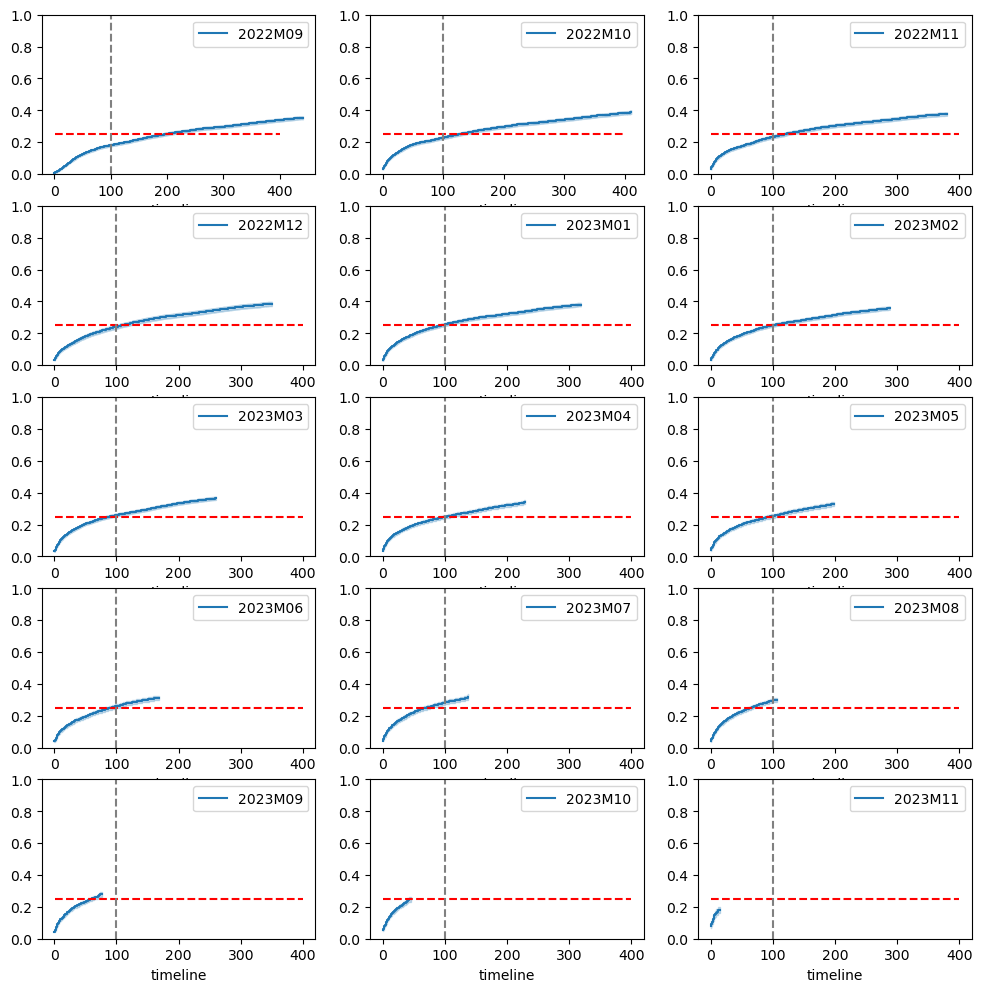

In [123]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 3, figsize=(12, 12))

tms = list(orders.Order_tm.unique())
tms.sort()
for i, ax in enumerate(axes.flatten()):
    temp = orders.loc[
        (orders.userreg_tm == tms[i])&
        (orders.row_no == 1) 
        ]
    if len(temp) != 0:
        kmf = KaplanMeierFitter()
        kmf.fit(
            durations = (temp.duration), 
            event_observed = temp.is_order.astype(int) , 
            label = f"{tms[i]}"
            ).plot_cumulative_density(ax = ax)
    ax.set_ylim(0, 1)
    ax.hlines(0.25,  xmin=0.5, xmax=400, color='r', linestyle='--')
    ax.vlines(100,  ymin=0, ymax=1, color='grey', linestyle='--')